<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/classification_option1_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hybrid model
  This notebook is trying to build option-1 which includes classification followed by detection.

Classification:
  1. ChexNet- Densnet121 - This has been implemented here.
  2. VGG NET
  3. InceptionV3
  4. **InceptionRestNetV2** This has been implemented here

Detection:
  RetinaNet based architecture
  1. ResNet101 
  2. ResNet152

In [63]:
import os

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [66]:
#Set global parameters here
BASE_MODEL = "InceptionResNetV2"
MODEL_NAME  = "Option-1" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best_299.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history_299.csv"
BATCH_SIZE = 16
IMAGE_SIZE = 299 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training
DROPOUT = 0.25 # [0, 0.25, 0.5]
DENSE_COUNT = 128 # [32, 64, 128, 256]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
ALPHA = 1.0
EPOCHS = 5

In [67]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
Setting baseModel : InceptionResNetV2
<module 'tensorflow.keras.applications.inception_resnet_v2' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/inception_resnet_v2/__init__.py'>
global BaseModel; BaseModel =np.InceptionResNetV2
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function InceptionResNetV2 at 0x7f70be4e5ae8> <function preprocess_input at 0x7f70be4e5c80>


In [68]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.inception_resnet_v2.InceptionResNetV2>,
 <function tensorflow.python.keras.applications.inception_resnet_v2.preprocess_input>)

In [69]:
shape = MODEL_MAP[BASE_MODEL]['input_shape']
IMAGE_SIZE = shape[0]
print('{}:IMAGE_SIZE, {}:Model Input Shape'.format(IMAGE_SIZE,shape))

299:IMAGE_SIZE, (299, 299, 3):Model Input Shape


In [70]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [71]:

# CLASS_VECTORS = get_class_map(full_df)

In [72]:
full_df.head(2)

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...


In [73]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [74]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [75]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df,target='class')

(21347, 14) training data
(5337, 14) raw validation data
(2668, 14) Validation data
(2669, 14) test data


In [76]:
unbalanced_train_df[unbalanced_train_df.class_id == 0].shape[0]

4809

12624 Final training size


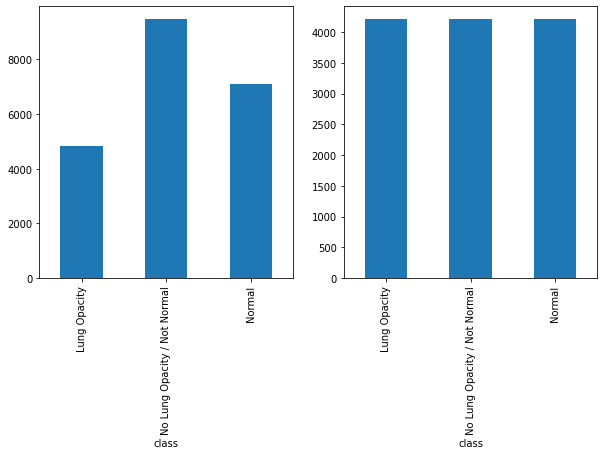

In [77]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 12624 # 4208 x 3 class targets
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES,target='class')
print(train_df.shape[0], 'Final training size')

## Build model

In [78]:
len(np.unique(train_df["path"].to_numpy()))

12624

In [79]:
# BATCH_SIZE = 8
# IMAGE_SIZE = 224
# IMG_WIDTH = 1024
train_gen = MyLabelDataGenerator(train_df)
valid_gen = MyLabelDataGenerator(valid_df)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

12624 :No of generator Image
2668 :No of generator Image
789 # of iterations in one train epoch
166 # of iterations in one validate epoch


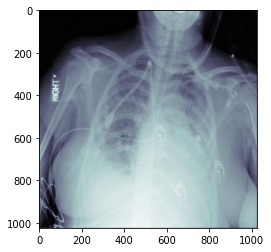

In [80]:
path = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('path')
img = train_gen.getImage(path)
plt.imshow(img, cmap=plt.cm.bone)

In [81]:
imageSet = train_gen[9][0]
maskSet = train_gen[9][1]   #Label

In [82]:
imageSet.shape,maskSet.shape

((16, 299, 299, 3), (16, 3))

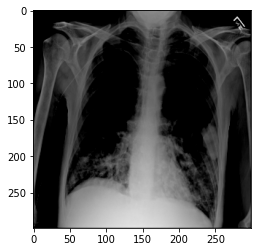

In [83]:
plt.imshow(imageSet[9], cmap=plt.cm.bone)

In [84]:

def build_pretrained_model():
  #Build base model
  input_shape = MODEL_MAP[BASE_MODEL]['input_shape']
  base_pretrained_model = BaseModel(input_shape =  input_shape, 
                              include_top = False, weights = 'imagenet')
  base_pretrained_model.trainable = False
  #Build Top layer
  lastlayer = MODEL_MAP[BASE_MODEL]['last_conv_layer']
  lastlayershape = base_pretrained_model.get_layer(lastlayer).output_shape[1:]
  pt_features = Input(lastlayershape, name = 'feature_input')
    
  bn_features = BatchNormalization()(pt_features)
  gap = GlobalAveragePooling2D()(bn_features)

  gap_dr = Dropout(DROPOUT)(gap)
  dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
  dr_steps = BatchNormalization()(dr_steps)
  dr_steps = layers.LeakyReLU(0.1)(dr_steps)
  out_layer = Dense(3, activation = 'softmax')(dr_steps)

  attn_model = Model(inputs = [pt_features], 
                    outputs = [out_layer], name = 'top_model')
  #Combine base & top model
  pneu_model = Sequential(name = 'combined_model')
  # base_pretrained_model.trainable = False
  pneu_model.add(base_pretrained_model)
  pneu_model.add(attn_model)
  #Add loss & optimizer
  lr = LEARN_RATE
  decay = lr/10 # or in the factor of 10
  adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
  pneu_model.compile(optimizer =adamOptimizer, loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
  
  return pneu_model,base_pretrained_model,attn_model

In [85]:
class_model,base_model,top_model = build_pretrained_model()
class_model.summary()

Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
top_model (Functional)       (None, 3)                 203651    
Total params: 54,540,387
Trainable params: 200,323
Non-trainable params: 54,340,064
_________________________________________________________________


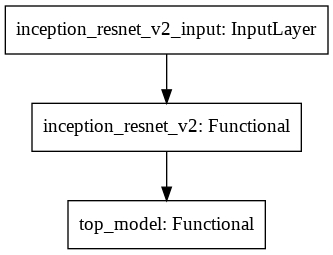

In [86]:
from keras.utils.vis_utils import plot_model
plot_model(class_model)

In [87]:
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

##Model Fit

In [88]:
%%time
history = pd.DataFrame()

if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  class_model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    class_model.load_weights(WEIGHTS_FILE)
  history = class_model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=callbacks_list,
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

Epoch 1/5
789/789 [==============================] - ETA: 0s - loss: 0.9454 - categorical_accuracy: 0.5644
Epoch 00001: val_loss improved from inf to 0.83093, saving model to Option-1.InceptionResNetV2/weights.best_299.h5
789/789 [==============================] - 3563s 5s/step - loss: 0.9454 - categorical_accuracy: 0.5644 - val_loss: 0.8309 - val_categorical_accuracy: 0.6002
Epoch 2/5
789/789 [==============================] - ETA: 0s - loss: 0.8374 - categorical_accuracy: 0.6128
Epoch 00002: val_loss improved from 0.83093 to 0.78309, saving model to Option-1.InceptionResNetV2/weights.best_299.h5
789/789 [==============================] - 328s 416ms/step - loss: 0.8374 - categorical_accuracy: 0.6128 - val_loss: 0.7831 - val_categorical_accuracy: 0.6242
Epoch 3/5
789/789 [==============================] - ETA: 0s - loss: 0.8064 - categorical_accuracy: 0.6253
Epoch 00003: val_loss improved from 0.78309 to 0.78164, saving model to Option-1.InceptionResNetV2/weights.best_299.h5
789/789 [=

## History

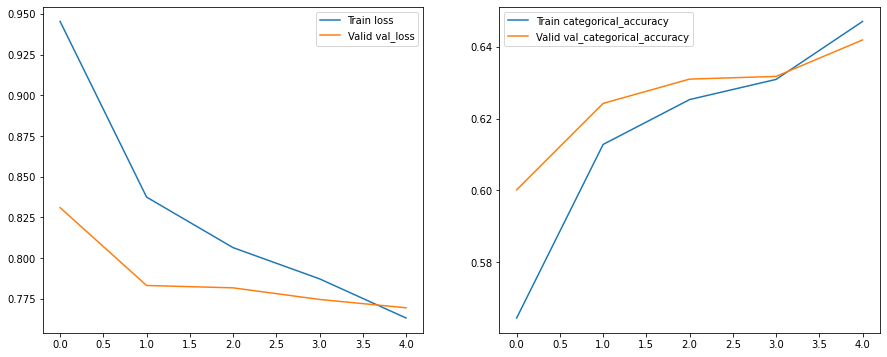

In [89]:
plot_his(history,'categorical_accuracy')
#Save the model as well for future use

## Classification-Stage1 performance

In [90]:
predict_gen = MyLabelTestDataGenerator(train_df)

12624 :No of generator Image


In [91]:
patients, pred_Y,valid_Y = class_predict(predict_gen,class_model,no_of_batch=0)


100%|██████████| 789/789 [06:30<00:00,  2.02it/s]


                              precision    recall  f1-score   support

                Lung Opacity       0.71      0.70      0.71      4208
No Lung Opacity / Not Normal       0.61      0.52      0.56      4208
                      Normal       0.75      0.86      0.80      4208

                    accuracy                           0.70     12624
                   macro avg       0.69      0.70      0.69     12624
                weighted avg       0.69      0.70      0.69     12624



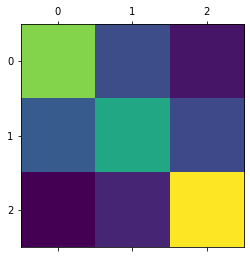

In [92]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

### ROC AUC

In [93]:
type(valid_Y[0])

numpy.ndarray

In [105]:
np.argmax(valid_Y,-1)==0

array([False, False, False, ..., False, False, False])

In [95]:
# from sklearn.metrics import roc_curve, roc_auc_score
# fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y)
# fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
# ax1.plot(fpr, tpr, 'b.-', label = 'DenseNet1 (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y))
# ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
# ax1.legend(loc = 4)
# ax1.set_xlabel('False Positive Rate')
# ax1.set_ylabel('True Positive Rate');
# ax1.set_title('Lung Opacity ROC Curve')

## Generate class prediction

In [129]:
pred_df = get_prediction_map(patients,pred_Y)

In [130]:
pred_df.reset_index(inplace=True)
# pred_df.columns = ['patientId', 'PNEUMONIA', 'NOT_NORMAL', 'NORMAL']

pred_df.rename(columns={'index':'patientId'},inplace=True)
pred_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL
0,c76aa53f-ef52-41b4-827c-4fa7ccbd26e1,0.031641,0.369000,0.599359
1,5480fc2a-1d5b-49a8-9e66-7e8b76aef97a,0.151872,0.389743,0.458385
2,eefe766c-7628-48a6-be6f-f464945b06da,0.656788,0.339746,0.003466
3,f320d4f9-9c2b-4b13-aae5-5c9e751a2e45,0.329035,0.428885,0.242079
4,06e09ebb-cb5b-4c30-8d3a-67a6ec34692b,0.439853,0.382535,0.177611


In [135]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12624 entries, 0 to 12623
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   12624 non-null  object 
 1   PNEUMONIA   12624 non-null  float64
 2   NOT_NORMAL  12624 non-null  float64
 3   NORMAL      12624 non-null  float64
dtypes: float64(3), object(1)
memory usage: 394.6+ KB


In [132]:
pred_dump_file = MODEL_NAME + '/class_prediction_299.csv'
if (os.path.isfile(pred_dump_file)):
  os.remove(pred_dump_file)

In [133]:
#Dump the prediction as it is very time consuming task.

import pandas as pd

if (os.path.isfile(pred_dump_file)):
  global pred_df
  pred_df = pd.read_csv(pred_dump_file)
else:
  pred_df.to_csv(pred_dump_file)

In [134]:
# pred_df.drop(pred_df.columns[0],inplace=True,axis=1)

In [136]:
merged_pred_meta_df = get_pred_merged_meta_data(pred_df,full_df)
merged_pred_meta_df.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
c76aa53f-ef52-41b4-827c-4fa7ccbd26e1,0.031641,0.369000,0.599359,85.0,1.0,0.0,0.0
5480fc2a-1d5b-49a8-9e66-7e8b76aef97a,0.151872,0.389743,0.458385,43.0,0.0,1.0,0.0
eefe766c-7628-48a6-be6f-f464945b06da,0.656788,0.339746,0.003466,30.0,1.0,1.0,0.0
f320d4f9-9c2b-4b13-aae5-5c9e751a2e45,0.329035,0.428885,0.242079,52.0,0.0,0.0,0.0
06e09ebb-cb5b-4c30-8d3a-67a6ec34692b,0.439853,0.382535,0.177611,46.0,1.0,1.0,1.0


In [137]:
merged_pred_meta_df.reset_index(inplace=True)
merged_pred_meta_df.rename(columns={'index':'patientId'},inplace=True)
merged_pred_meta_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
0,c76aa53f-ef52-41b4-827c-4fa7ccbd26e1,0.031641,0.369000,0.599359,85.0,1.0,0.0,0.0
1,5480fc2a-1d5b-49a8-9e66-7e8b76aef97a,0.151872,0.389743,0.458385,43.0,0.0,1.0,0.0
2,eefe766c-7628-48a6-be6f-f464945b06da,0.656788,0.339746,0.003466,30.0,1.0,1.0,0.0
3,f320d4f9-9c2b-4b13-aae5-5c9e751a2e45,0.329035,0.428885,0.242079,52.0,0.0,0.0,0.0
4,06e09ebb-cb5b-4c30-8d3a-67a6ec34692b,0.439853,0.382535,0.177611,46.0,1.0,1.0,1.0


In [138]:
merged_pred_meta_df[merged_pred_meta_df.Target==1].sample(5)

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
3152,3bd214a7-b62f-4e31-93c5-9cea5c2a8a30,0.585179,0.376441,0.038380,62.0,1.0,0.0,1.0
7508,bab8d182-b9fe-4db9-88b5-042153c4406e,0.739154,0.258293,0.002553,71.0,1.0,1.0,1.0
12452,084aa98a-91aa-45d8-aa52-4fad8344b0bf,0.601360,0.370153,0.028487,37.0,0.0,1.0,1.0
6859,16939adb-3468-4e45-9b87-0ec9a8b0f2ea,0.853694,0.142353,0.003953,20.0,1.0,0.0,1.0
10107,f1ba9810-861e-4ffc-8fbf-242d5da8e80d,0.975462,0.024532,0.000006,28.0,1.0,1.0,1.0


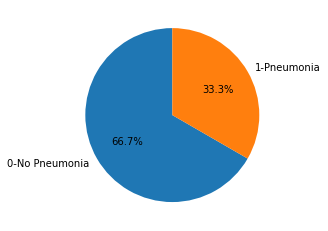

In [139]:
import matplotlib.pyplot as plt
import numpy as np
unique_values, count = np.unique(merged_pred_meta_df['Target'], return_counts=True)

plt.pie(count, labels = ['0-No Pneumonia', '1-Pneumonia'],
          autopct='%1.1f%%', startangle=90)
plt.show()
#Need to balance the data here.

In [140]:
#Split the data into train & valid
y = merged_pred_meta_df['Target'].to_numpy()
X = merged_pred_meta_df[merged_pred_meta_df.columns[1:7]]

In [141]:
X.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition
0,0.031641,0.369000,0.599359,85.0,1.0,0.0
1,0.151872,0.389743,0.458385,43.0,0.0,1.0
2,0.656788,0.339746,0.003466,30.0,1.0,1.0
3,0.329035,0.428885,0.242079,52.0,0.0,0.0
4,0.439853,0.382535,0.177611,46.0,1.0,1.0


In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## FFNN model

In [143]:
#Build neural netwrok

from tensorflow.keras.layers import  Reshape
def add_layer(model):
  kinit ='he_normal' #tf.keras.initializers.he_normal()
  actv = 'relu' #activation.relu
  # model.add(Reshape((6,),input_shape=(32,32,)))
  # #Add batch normalization to avoid NAN in training loss
  # model.add(kl.normalization.BatchNormalization())
  #Add input layer -- 
  model.add(Dense(6,input_dim= 6,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #How many hidden layer? No clear rule, trial & error? Literature says, it 3 hidden layer sufficient
  #Add hidden layer -1
  model.add(Dense(16,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -2
  model.add(Dense(8,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -3
  model.add(Dense(4,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())


  #Add output layer -- number of output neoron 1(as the number of output is 10)
  #Add hidden layer -1
  model.add(Dense(1,activation='sigmoid',kernel_initializer=kinit))
  
nn_model = Sequential()
add_layer(nn_model)

In [144]:
def fit_model(opt,model,epoch=60,verbo=1,batchsize=128):
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test),batch_size=batchsize, epochs=epoch, verbose=verbo)
  return history
opt = Adam(lr = LEARN_RATE)
history = fit_model(opt,nn_model)

Epoch 1/60
89/89 [==============================] - 1s 7ms/step - loss: 0.9872 - accuracy: 0.5448 - val_loss: 0.8964 - val_accuracy: 0.5748
Epoch 2/60
89/89 [==============================] - 0s 5ms/step - loss: 0.9340 - accuracy: 0.5573 - val_loss: 0.7953 - val_accuracy: 0.5424
Epoch 3/60
89/89 [==============================] - 0s 5ms/step - loss: 0.8938 - accuracy: 0.5738 - val_loss: 0.7956 - val_accuracy: 0.5661
Epoch 4/60
89/89 [==============================] - 0s 5ms/step - loss: 0.8533 - accuracy: 0.5829 - val_loss: 0.7788 - val_accuracy: 0.5764
Epoch 5/60
89/89 [==============================] - 0s 5ms/step - loss: 0.8157 - accuracy: 0.5904 - val_loss: 0.7551 - val_accuracy: 0.5740
Epoch 6/60
89/89 [==============================] - 0s 5ms/step - loss: 0.7761 - accuracy: 0.5946 - val_loss: 0.7377 - val_accuracy: 0.5669
Epoch 7/60
89/89 [==============================] - 0s 5ms/step - loss: 0.7347 - accuracy: 0.5926 - val_loss: 0.7309 - val_accuracy: 0.5645
Epoch 8/60
89/89 [==

In [145]:
HISTORY_FILE = MODEL_NAME+"/" +"history_FFNN.csv"
his_ffnn = saveHistory(history,HISTORY_FILE)

## Classification Performance(Recall)

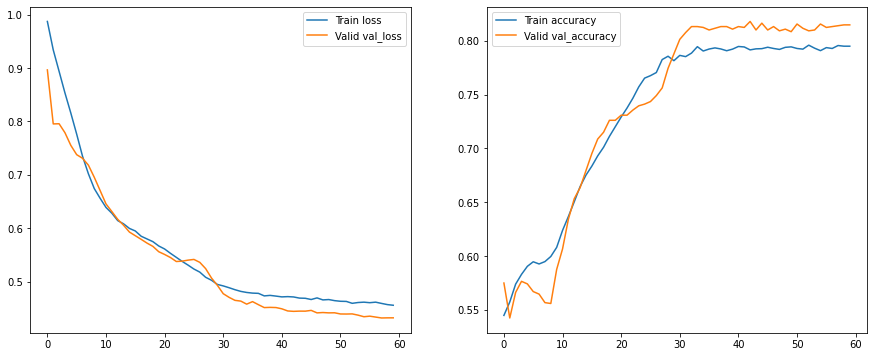

In [146]:
plot_his(his_ffnn,'accuracy')

In [147]:
pred_y = nn_model.predict(X_test)

In [148]:
pred_y

array([[0.37061965],
       [0.3633908 ],
       [0.10388947],
       ...,
       [0.6572998 ],
       [0.07440966],
       [0.08985895]], dtype=float32)

In [149]:
pred_y_class = (pred_y >= 0.45).astype(np.int)

In [150]:
y_test = (y_test >= 0.5).astype(np.int)


In [151]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_test, pred_y_class), "\n")
print("Classification Report:- \n", metrics.classification_report(y_test, pred_y_class))

Confusion Matrix:- 
 [[733 112]
 [126 292]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       845
           1       0.72      0.70      0.71       418

    accuracy                           0.81      1263
   macro avg       0.79      0.78      0.79      1263
weighted avg       0.81      0.81      0.81      1263



### ROC curve

Text(0.5, 1.0, 'Lung Opacity ROC Curve')

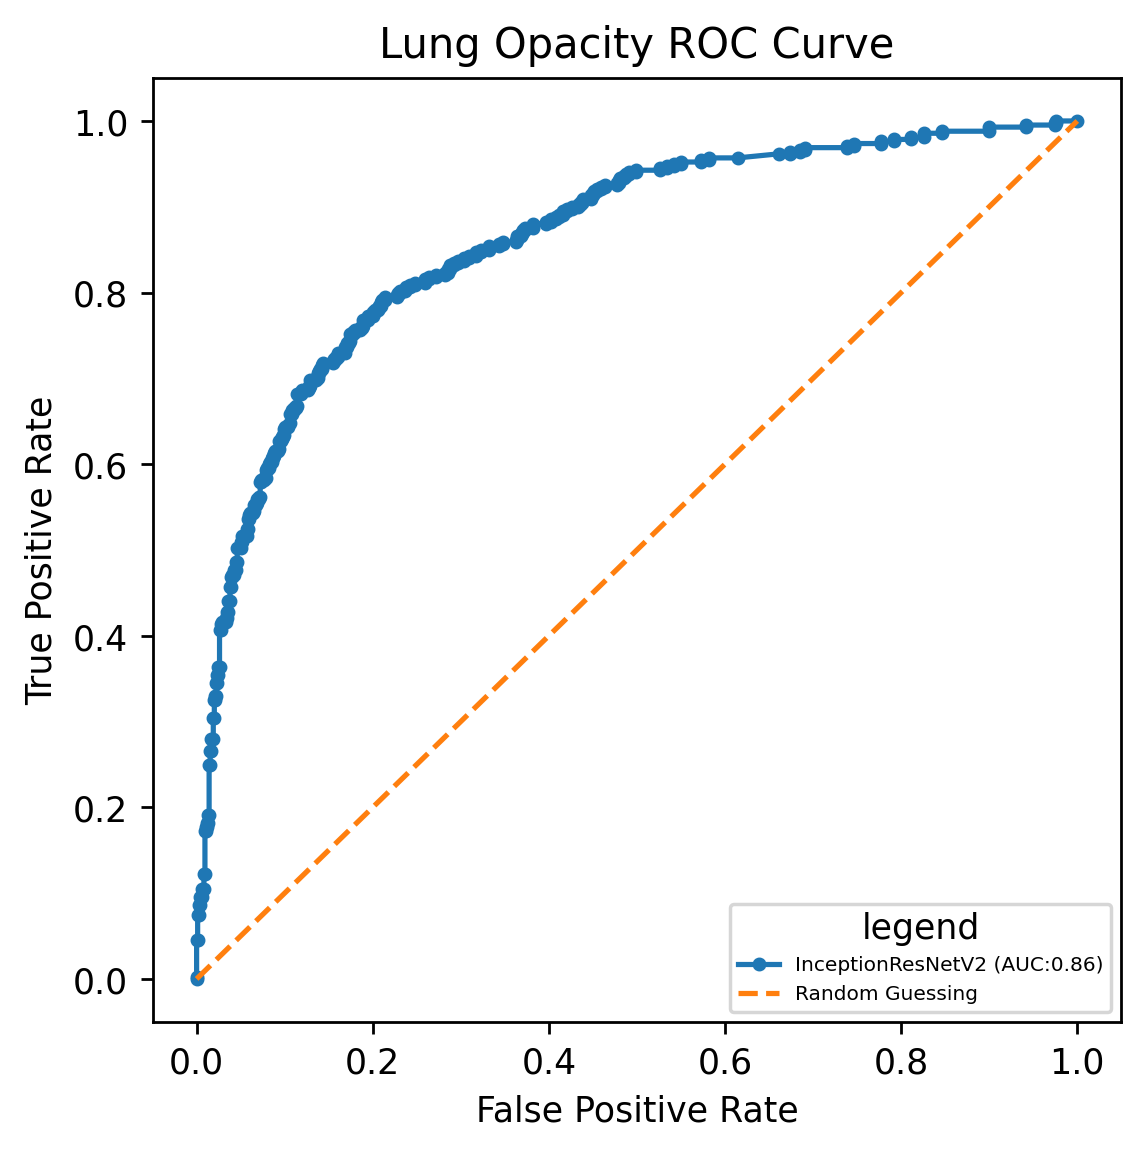

In [153]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')
fpr, tpr, _ = roc_curve(y_test, pred_y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, marker='.', label = 'InceptionResNetV2 (AUC:%2.2f)' % roc_auc_score(y_test, pred_y))
ax1.plot(fpr, fpr, linestyle='--', label = 'Random Guessing')
ax1.legend(title='legend',  loc='lower right', prop=fontP)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

## Conclusion